# Extracting a median centreline from an oriented 3d point cloud

This notebook follows the step by step extraction of a centreline from a point pcCave. The following limitation currently applies: the cave passage topology must fit in a planar graph, so overlapping passages are not supported.

The following calculations are performed: 
1. The cave point cloud (``pcCave``) is projected onto a plane by setting the Z coordinate to 0. A scalar field named ``isCave`` is added to the dataset.
2. A rectangular plane (``msPlane``) is sown with randomly distributed points (``pcPlane``), who are then given the value of scalar field ``isCave`` by interpolating this value from the projected cave point cloud scalar field. Points within the projected cave outline are thus given the value **1** while those outside are given **nan**.
3. The planar point cloud is split between the values inside (``isCave``) and outside (``notIsCave``).
4. A cloud to cloud distance is computed between ``isCave`` and ``notIsCave``, using the outside as reference. The distance computed is 0 at the boundary and increases towards the centerline, with a maximum distance to the point pcCave. 
5. Setting this distance as a Z coordinate, the roughness is calculated. Within a chosen radius, a plane is fitted to each point neighbourhood and the distance from the point of interest to this plane is the value of roughness returned. In a sense, this can be thought of as the curvature of the scalar field.
6. This new scalar field is then thresholded, with high positive values describing the centre crest of the 2d plot of X, Y, and maxdistance, kept as a ``centreline`` point pcCave. Because of its high linearity, this point cloud can be spatially subsampled aggressively, yielding a few hundred points remaining to describe the nodes of the extracted centreline.
7. A new scalar field is added to the thresholded and subsampled point set, namely, the interpolated Z coordinate of the projected cave point pcCave. The median Z value within a given sphere radius is attributed to each point of this centreline point pcCave.
8. The final step is to turn the point cloud into an oriented graph.

In [1]:
# start with the imports
import cloudComPy as cc
import os
import numpy as np

import matplotlib.pyplot as plt

from yaml import load
from yaml.loader import Loader
from sklearn.neighbors import NearestNeighbors


In [ ]:
p

## 1. Read the point cloud dataset and project it onto a horizontal plane with zero altitude

In [296]:

RAW_CLOUD_FILEPATH = "../../real_data/3e_Galerie_subsampled.ply"
GLOBAL_SHIFT = [-537800, -195100, 0]
# load the point cloud to memory but because it is georeferenced the x and y coordinates are very large.
# so we subtract the global shift determined in the processing parameters.
pcCave = cc.loadPointCloud(RAW_CLOUD_FILEPATH, cc.CC_SHIFT_MODE.XYZ, 0, *GLOBAL_SHIFT)

In [297]:
# add new scalar fields, these are initialised with a value of 0. So we fill the isCave field with 1s.
pcCave.addScalarField("Z0")

pcCave.addScalarField("isCave")
sf = pcCave.getScalarField("isCave")
sf.fill(1)   # access to Numpy array, without copy

In [298]:
# because we are going to project the cloud onto a plane, we save the original Z coordinate 
# as a scalar which we are going to retrieve later on.
isXexported=False
isYexported=False
isZexported=True

pcCave.exportCoordToSF(isXexported, isYexported, isZexported)

True

In [299]:
# extracting the coordinates as an np.array
coords = pcCave.toNpArrayCopy()
# setting Z0 as the coordinate z to project the original point cloud onto a plane at altitude 0.
coords[:,2] = pcCave.getScalarField("Z0").toNpArrayCopy()
# setting the cloud coordinates from the updated np.array
pcCave.coordsFromNPArray_copy(coords)

In [300]:
# Since Z0 is the scalar field we want to interpolate later, we set it to be the currently displayed scalar field.
pcCave.setCurrentDisplayedScalarField(2)
pcCave.setCurrentScalarField(2)

## 2. Sow a plane with randomly distributed points

We now create a plane, in the form of a CloudCompare primitive. It is defined by a width, a height and a transformation matrix. In our case, we only want grow the cave point cloud bounding box very slightly and centre the plane on the middle of this box. Therefore the transformation matrix only looks like a translation. 

To achieve this we use the ``getOwnBB()`` method from a ccPointCloud object and further extract the minimum and maximum coordinates from its corners.

In [301]:
# calculate height and width 5 % greater than the cloud's bounding box. 
xwidth = 1.05 * (pcCave.getOwnBB().maxCorner()[0] - pcCave.getOwnBB().minCorner()[0])
ywidth = 1.05 * (pcCave.getOwnBB().maxCorner()[1] - pcCave.getOwnBB().minCorner()[1])

# calculate the centre of the point cloud bounding box, around which to define a plane 
xmid = 0.5 * (pcCave.getOwnBB().maxCorner()[0] + pcCave.getOwnBB().minCorner()[0])
ymid = 0.5 * (pcCave.getOwnBB().maxCorner()[1] + pcCave.getOwnBB().minCorner()[1])

In [302]:
x, y, z = pcCave.getGlobalShift()

print(x, y, z)

-537800.0 -195100.0 0.0


In [303]:
# set up the transformation matrix. The first 3 x 3 rows and columns are an identity matrix. The last column contains the translation parameters
# these centre the plane over the projected cave point cloud without changing its height
transMatrix = np.array([[1,0,0,xmid],[0,1,0,ymid],[0,0,1,0],[0,0,0,1]])

transMatrix

array([[ 1.        ,  0.        ,  0.        , 13.76999664],
       [ 0.        ,  1.        ,  0.        , 84.79999924],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [304]:
# in the syntax below, we need to flatten the 16 parameters of the matrix transpose.
transMatrix = cc.ccGLMatrix(transMatrix.T.flatten())

In [305]:
# this is the critical step where a cloud compare primitive is created.
msPlane = cc.ccPlane(xwidth, ywidth, transMatrix)

In [306]:
# now we randomly sow some points on this plane and create a point cloud restricted to the plane.
pcPlane = msPlane.samplePoints(densityBased = True, samplingParameter = 900, withNormals=False, withTexture=False)

## 3. Interpolate the ``isCave`` attribute to the planar point cloud

In [307]:
dic = pcCave.getScalarFieldDic()
print(dic)

{'CANUPO.class': 3, 'CANUPO.confidence': 4, 'Coord. Z': 7, 'Intensity': 0, 'Number Of Returns': 2, 'Return Number': 1, 'Z0': 5, 'isCave': 6}


In [308]:
# some setting up, defining the interpolation parameters. 
# we interpolated with the normal distance using a radius of 0.1 m 
params = cc.interpolatorParameters()
params.method = cc.INTERPOL_METHOD.RADIUS
params.algos = cc.INTERPOL_ALGO.NORMAL_DIST
params.radius = 0.1
params.sigma = 0.06
sfIndexes = [dic['isCave']]


In [309]:
ret = cc.interpolateScalarFieldsFrom(pcPlane, pcCave, sfIndexes, params, octreeLevel=10)

In [310]:
print(pcPlane.getScalarFieldDic())
# in order to split this planar point cloud between pcIsCave and pcNotIsCave clouds, we need to 
# first set the current scalar field to isCave, e.g. the zeroth element. 
pcPlane.setCurrentDisplayedScalarField(0) 
pcPlane.setCurrentScalarField(0) 

{'isCave': 0}


In [311]:
# split cloud by a value of 1. Anything below 1 is not cave, anything above is a cave. 
# by setting equal bounds but choosing to retain clouds outside or inside the interval
# we get the point clouds below.
pcIsCave = pcPlane.filterPointsByScalarValue(minVal = 1, maxVal=2, outside = False)
pcNotIsCave = pcPlane.filterPointsByScalarValue(minVal = 1, maxVal=2, outside = True)


## 4. Cloud to Cloud distance computation

In [312]:
# compute cloud to cloud distance between those two clouds
cc.DistanceComputationTools.computeApproxCloud2CloudDistance(pcIsCave, pcNotIsCave,
                                                            octreeLevel=10)

[0.0,
 2.9867231845855713,
 1.2106508016586304,
 0.546698808670044,
 0.027863526716828346]

In [313]:
# the distance computation creates a new scalar field called "Approx. distances" with index 1. 
pcIsCave.getScalarFieldDic()

{'Approx. distances': 1, 'isCave': 0}

## 5. Gradient computation 

In [314]:
pcIsCave.computeScalarFieldGradient(SFindex=1,
                                    radius = 0.5, 
                                    euclideanDistances = False,
                                    theOctree= pcIsCave.computeOctree())


True

In [315]:
pcIsCave.getScalarFieldDic()

{'Approx. distances': 1, 'Gradient norms(Approx. distances)': 2, 'isCave': 0}

In [316]:
# extracting the coordinates as an np.array
coords = pcIsCave.toNpArrayCopy()
# setting the distance as the z value of the point cloud coordinates.
coords[:,2] = pcIsCave.getScalarField("Approx. distances").toNpArrayCopy()
# set the point cloud coordinates from the updated array.
pcIsCave.coordsFromNPArray_copy(coords)


In [317]:
print(pcIsCave.getScalarFieldDic())


{'Approx. distances': 1, 'Gradient norms(Approx. distances)': 2, 'isCave': 0}


In [318]:
def squish(x, d, k): 
    return  1 / 2 * (1 + (np.exp(-2*(x-d)*k ) - 1) / (np.exp(-2*(x-d)*k) + 1))

In [319]:
gradient = pcIsCave.getScalarField(2).toNpArrayCopy()
distance = pcIsCave.getScalarField(1).toNpArrayCopy()

In [320]:
# threshold the gradient scalar field by quantile
q = 0.5
quantile = np.quantile(distance, q)

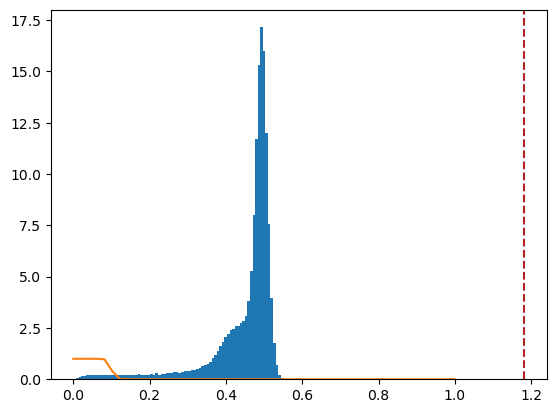

In [321]:
plt.hist(gradient, bins = 100, density = True)
xi = np.linspace(0, 1)
plt.plot(xi, squish(xi, 0.1, 100), color = "C1")

plt.axvline(quantile, ls = "--", color = "firebrick")

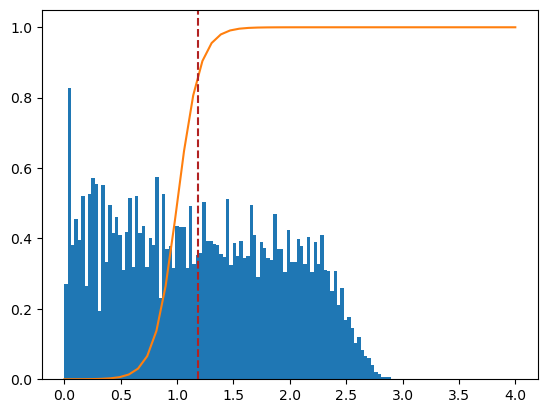

In [322]:
plt.hist(distance, bins = 100, density = True)
xi = np.linspace(0, 4)
plt.plot(xi, 1 - squish(xi, 1, 5), color = "C1")
plt.axvline(quantile, ls = "--", color = "firebrick")

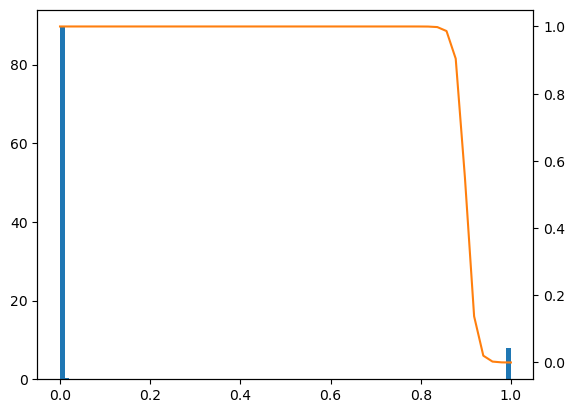

In [323]:
intersection = squish(gradient, 0.4, 100) * (1 - squish(distance, 1, 5))


xi = np.linspace(0, 1)
fig, ax = plt.subplots()
ax.hist(intersection, bins = 100, density = True)
ax2 = ax.twinx()

ax2.plot(xi, squish(xi, 0.9, 50), color = "C1")


C:\Users\racinet\AppData\Local\Temp\ipykernel_18624\365717910.py:2: RuntimeWarning: overflow encountered in exp
  return  1 / 2 * (1 + (np.exp(-2*(x-d)*k ) - 1) / (np.exp(-2*(x-d)*k) + 1))
C:\Users\racinet\AppData\Local\Temp\ipykernel_18624\365717910.py:2: RuntimeWarning: invalid value encountered in true_divide
  return  1 / 2 * (1 + (np.exp(-2*(x-d)*k ) - 1) / (np.exp(-2*(x-d)*k) + 1))


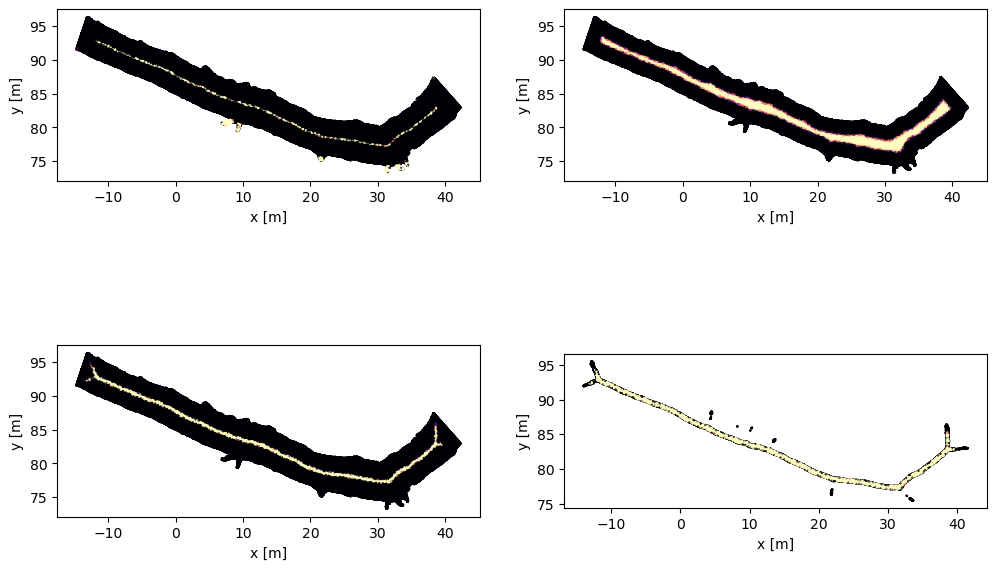

In [324]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))


ax1.scatter(coords[:,0], coords[:,1], s = 0.2, zorder = -100, c = squish(gradient, 0.2, 100), cmap = "magma")
ax2.scatter(coords[:,0], coords[:,1], s = 0.2, zorder = -100, c = 1 - squish(distance, 2, 10), cmap = "magma")
ax3.scatter(coords[:,0], coords[:,1], s = 0.2, zorder = -100, c = intersection, cmap = "magma")
ax4.scatter(coords[:,0], coords[:,1], s = 0.2, zorder = -100, c = 1 - squish(intersection, 0.9, 50), cmap = "magma")

for ax in (ax1, ax2, ax3, ax4):
    ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

plt.show()


In [325]:
# add the isCentreline criterion to points. 
pcIsCave.addScalarField("isCentreline")
sf = pcIsCave.getScalarField("isCentreline")
sf.fromNpArrayCopy(intersection)

In [326]:
# split cloud by a value of a given quantile. Anything below 0.99 is considered not to be part of the centreline
pcIsCave.setCurrentDisplayedScalarField(3)
pcIsCaveMedialAxis = pcIsCave.filterPointsByScalarValue(minVal = 0, maxVal = 0.99,outside = True)

## 6. Subsample the thresholded medial axis and extract largest connected component

In [373]:
# now we can subsample aggressively (so we get linearly arranged centrelines) 
# minimum sampling distance defined to get rid of an many points as possible without losing linearity.
refCloud = cc.CloudSamplingTools.resampleCloudSpatially(pcIsCaveMedialAxis, 1)

(pcIsCaveMedialAxisSparse, res) = pcIsCaveMedialAxis.partialClone(refCloud)
pcIsCaveMedialAxisSparse.setName("spatiallyResampledCaveMedianLargest")

In [380]:
pcCave.getScalarFieldDic()

{'CANUPO.class': 3,
 'CANUPO.confidence': 4,
 'Coord. Z': 7,
 'Intensity': 0,
 'Number Of Returns': 2,
 'Return Number': 1,
 'Z0': 5,
 'isCave': 6}

In [375]:
# we create an empty scalar field Z0.
pcIsCaveMedialAxisSparse.addScalarField("Z0")
print(psIsCaveMedialAxisSparse.getScalarFieldDic())


{'Approx. distances': 1, 'Gradient norms(Approx. distances)': 2, 'Z0': 4, 'isCave': 0, 'isCentreline': 3}


In [381]:
# now we reproject the centreline onto a horizontal plane to interpolate the median Z value of the original point cloud at each point. 
coords = pcIsCaveMedialAxisSparse.toNpArrayCopy()
coords[:,2] = pcIsCaveMedialAxisSparse.getScalarField("Z0").toNpArray()
# setting the coordinates of the point cloud using the updated np.array
pcIsCaveMedialAxisSparse.coordsFromNPArray_copy(coords)

array([[-10.49816   ,  92.33119   ,   0.        ],
       [  8.210773  ,  84.234695  ,   0.        ],
       [ -1.5086422 ,  88.38938   ,   0.        ],
       [  2.2762394 ,  86.41464   ,   0.        ],
       [ -8.712942  ,  91.2883    ,   0.        ],
       [ -5.9011164 ,  90.274124  ,   0.        ],
       [  5.3041496 ,  85.25594   ,   0.        ],
       [  0.71180344,  87.414024  ,   0.        ],
       [ -2.9013968 ,  89.02314   ,   0.        ],
       [  7.142296  ,  84.515816  ,   0.        ],
       [  3.8457375 ,  86.222176  ,   0.        ],
       [ -7.513424  ,  91.091     ,   0.        ],
       [-11.911066  ,  93.342766  ,   0.        ],
       [ -4.4147587 ,  89.80555   ,   0.        ],
       [  9.988131  ,  83.524574  ,   0.        ],
       [ -9.492994  ,  91.97941   ,   0.        ],
       [ -0.2467413 ,  88.05127   ,   0.        ],
       [-12.205695  ,  94.17656   ,   0.        ],
       [-12.735207  ,  92.50003   ,   0.        ],
       [  6.116783  ,  84.69218

In [382]:
# interpolation using weighted distance from point. Using median within a radius of 5 m. 
params = cc.interpolatorParameters()
params.method = cc.INTERPOL_METHOD.RADIUS
params.algos = cc.INTERPOL_ALGO.NORMAL_DIST
params.radius = 5
params.sigma = 1
sfIndexes = [dic['Coord. Z']]



ret = cc.interpolateScalarFieldsFrom(pcIsCaveMedialAxisSparse, pcCave, sfIndexes, params, octreeLevel=10)

In [390]:
print(pcIsCaveMedialAxisSparse.getScalarFieldDic())

{'Approx. distances': 1, 'Coord. Z': 5, 'Gradient norms(Approx. distances)': 2, 'Z0': 4, 'isCave': 0, 'isCentreline': 3}


In [393]:
# finally we can set the interpolated coord Z value to be the Z coordinate of our centreline. 
coords = pcIsCaveMedialAxisSparse.toNpArrayCopy() 
coords[:,2] = pcIsCaveMedialAxisSparse.getScalarField("Coord. Z").toNpArrayCopy()

pcIsCaveMedialAxisSparse.coordsFromNPArray_copy(coords)

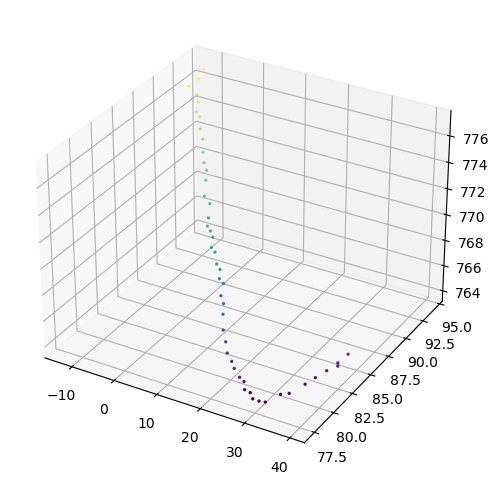

In [394]:
fig = plt.figure(figsize=(6, 6))

ax3d = fig.add_subplot(111, projection = "3d")
ax3d.scatter(coords[:,0], coords[:,1],coords[:,2], c = coords[:,2],  s = 2)


In [395]:
# do a nearest neighbour search with 3 as the number of neighbours, itself, and the nearest two other points. 
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(coords)

In [396]:
distances, indices = nbrs.kneighbors(coords)

In [397]:
# At the moment, this only reorders the points of line graph by their nearest neighbours. 
# need to update it and let it also do branches, but segment everything into branches. 
branches = []
branch_indices = []
base_idx = np.argmin(coords[:,0])
print(base_idx)
idx = np.arange(coords.shape[0], dtype=int)
processed_idx = [base_idx]

# Increasing a single step count.
current_step = 0

while len(processed_idx) < coords.shape[0]:
    # update the step
    current_step += 1


    # find index and distance of nearest neighbour
    nn_index = indices[base_idx][1]
    nn_distance = distances[base_idx][1]

    # if already processed, go to the next nearest neighbour. 
    if nn_index in processed_idx:
        nn_index = indices[base_idx][2]
        nn_distance = distances[base_idx][2]
        if nn_index in processed_idx:
            print("should do something, point already visited, in a triangle")
            nn_index = indices[base_idx][3]
            branches.append(branch_indices)
            branch_indices = []
    
    # find the distance of nearest neighbour

    base_idx = nn_index
    branch_indices.append(nn_index)
    processed_idx.append(nn_index)
    idx = np.in1d(idx, np.array(processed_idx), invert = True)
branches.append(branch_indices)
if len(branches) > 1:
    print("multiple branches found")

18
should do something, point already visited, in a triangle
should do something, point already visited, in a triangle
multiple branches found


In [398]:
branches

[[12, 17],
 [0,
  15,
  4,
  11,
  5,
  13,
  8,
  2,
  16,
  7,
  3,
  10,
  6,
  19,
  9,
  1,
  20,
  14,
  30,
  43,
  24,
  47,
  22,
  28,
  34,
  29,
  21,
  38,
  35,
  39,
  37,
  46,
  23,
  45,
  40,
  42,
  26,
  31,
  32,
  33,
  25,
  27,
  36,
  41],
 [44]]

In [399]:
# reorder the coordinates by indexing.
ordered_coords = coords[np.array(branches[1])]
georef_coords = ordered_coords - GLOBAL_SHIFT


In [400]:
georef_coords

array([[537789.50183964, 195192.33119202,    775.94915771],
       [537790.50700569, 195191.97940826,    775.64385986],
       [537791.28705788, 195191.28829956,    775.26580811],
       [537792.48657608, 195191.09100342,    775.10198975],
       [537794.09888363, 195190.27412415,    774.67803955],
       [537795.58524132, 195189.80554962,    774.23980713],
       [537797.09860325, 195189.02313995,    773.74829102],
       [537798.4913578 , 195188.38938141,    773.37182617],
       [537799.75325871, 195188.05126953,    773.06195068],
       [537800.71180344, 195187.41402435,    772.71270752],
       [537802.2762394 , 195186.41464233,    772.13171387],
       [537803.84573746, 195186.2221756 ,    771.79406738],
       [537805.30414963, 195185.2559433 ,    771.32122803],
       [537806.11678314, 195184.69217682,    771.06481934],
       [537807.14229584, 195184.51581573,    770.887146  ],
       [537808.21077347, 195184.23469543,    770.64855957],
       [537809.01467133, 195183.59837341

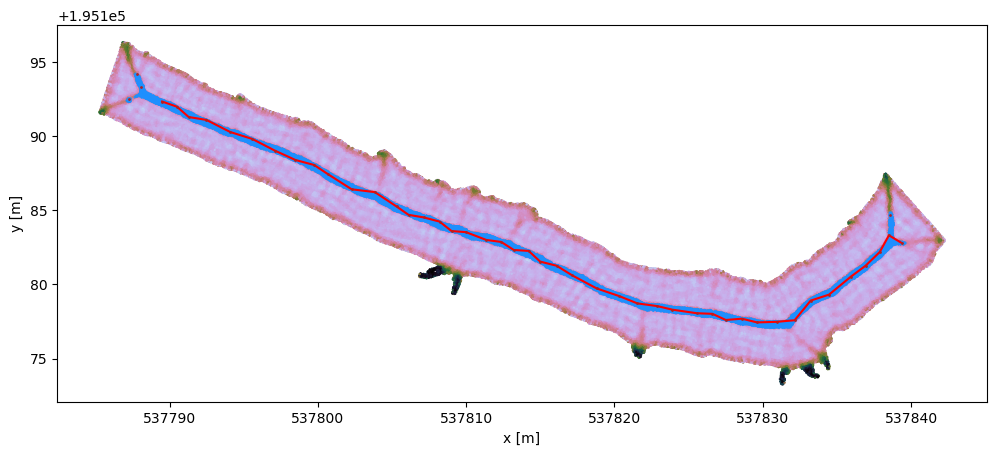

In [401]:
fig, ax = plt.subplots(figsize = (12, 12))


dense_medial = pcIsCaveMedialAxis.toNpArrayCopy() - GLOBAL_SHIFT
sparse_medial = pcCC0MedialAxis.toNpArrayCopy() - GLOBAL_SHIFT

dense_cave = pcIsCave.toNpArrayCopy() - GLOBAL_SHIFT
dense_cave_gradient  = pcIsCave.getScalarField(2).toNpArrayCopy()
ax.plot(georef_coords[:,0], georef_coords[:,1], color = "red")
ax.scatter(dense_medial[:,0], dense_medial[:,1], s = 0.2, zorder = -1, color = "dodgerblue")
ax.scatter(sparse_medial[:,0], sparse_medial[:,1], s = 1, zorder = 10, c = "firebrick")

ax.scatter(dense_cave[:,0], dense_cave[:,1], s = 0.2, zorder = -100, c = dense_cave_gradient, cmap = "cubehelix")

ax.set_aspect("equal")

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

plt.show()


In [402]:
# save to a polyline format. 
np.savetxt("../../real_data/3rdGalleryCentreline.poly", georef_coords)